# SISPS-AST9AH-Analysis

Analysis for Asterion HR12-9 9AH batteries for SISPS project.

Lawrence Stanton  
**March 2024**

## Document Information

| **uYilo Order No** | UCT002 |


## Imports and Configuration


In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modify default plotting style
plt.style.use('dark_background')  # <--- comment toggle per visual preference
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 5)
%config InlineBackend.figure_formats = ['svg']

## Environmental Test Chamber (ETC) Data Import


<Axes: title={'center': 'ETC Temperature and Set Point History'}, xlabel='Date/Time'>

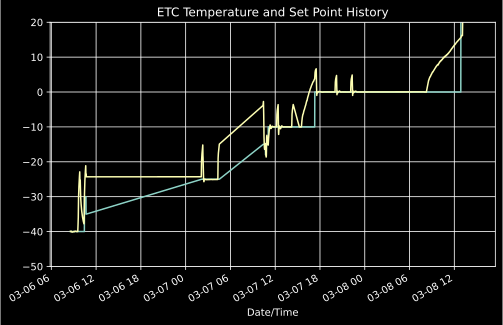

In [2]:
def readEtcFile(file):
	data = pd.read_csv(file,
					encoding='charmap',
					delimiter=';',
					usecols=['Date/Time', 'CV1_SP', 'CV1_AV'],
					parse_dates=['Date/Time'],
					date_format='%Y.%m.%d %H:%M:%S',
					)
	return data

def readAllEtcFiles(files):
	etc = None
	for file in files:
		data = readEtcFile(file)
		etc = pd.concat([etc, data])
	return etc

files = [
	"Data/ETC/Batch A/SERVICE-2024-03-06.csv",
	"Data/ETC/Batch A/SERVICE-2024-03-07.csv",
	"Data/ETC/Batch A/SERVICE-2024-03-08.csv",
]
etc = readAllEtcFiles(files)

# Dates might still need correction - settings change happened mid test
etc.plot(
	x='Date/Time',
	kind='line',
	ylim=(-50, 20),
	legend=False,
	title='ETC Temperature and Set Point History',
	grid=True,
	)


## Electrochemical Impedance Spectroscopy (EIS) Data Import


In [3]:
def readEisFile(file):
	headerRow = 30
	skipRow = lambda r: (r in range(0, headerRow-1)) or (r in range(headerRow, headerRow + 4)) # Constant offset for all EIS files.

	data = pd.read_csv(
		file,
		skiprows = skipRow,
		usecols = lambda col: col not in ["Voltage", "Current", "Cycle", "Cycle Level", "EisStart", "EisFinish", "AAcMax", "Unnamed: 42"],
	)

	metadata = pd.read_csv(
		file,
		nrows=23,
		skiprows=2,
		sep=',',
		names=['key', 'value'],
		)
	metadata = metadata.set_index('key').to_dict()['value']

	return (data, metadata)

def readAllEisFiles(files):
	eis = {}
	for file in files:
		data, metadata = readEisFile(file)
		eis[metadata['Comment']] = (data, metadata)
	return eis


def findAllEisFiles():
	files = []
	for root, dirs, file in os.walk('Data/EIS'):
		for f in file:
			if f.endswith('_EIS00001.csv'):
				files.append(os.path.join(root, f))
	return files

eis = readAllEisFiles(findAllEisFiles())


### EIS Data Preprocessing

- Sorting eis elements by test name.
- Known bad tests are removed from the main eis batch but saved separately for later reference if necessary.
- Special processing of A10 -20°C EIS data.

  > The measurement appeared corrupted in some data points due to the battery suspected of being frozen. When negative real values are removed however, the remaining pattern appears useful.


In [4]:
eis = dict(sorted(eis.items()))	# Helps legends greatly by plotting in alphabetical order

knownBadTests = [
	"UCT_AST_A01_-20 FAIL",
	"UCT_AST_A10_-20 FAIL",
	"UCT_AST_A03_-30 FAIL",
	"UCT_AST_A09_-30 FAIL",
	"UCT_AST_9AH_A04_-20_POC",
	"UCT_AST_9AH_A05_-20_POC",
	"UCT_AST_9AH_A06_-20_POC",
]

eisBadTests = {}
for badTest in knownBadTests:
	eisBadTests[badTest] = eis[badTest]
	del eis[badTest]
del badTest

# Special case filtering for obviously invalid rows of A10 -20°C tests
def a10badDataRowFilter(eis):
	for a10spectra in eis:
		if 'UCT_AST_A10_-20' in a10spectra:
			spectra = eis[a10spectra]
			# filter all rows where Zreal1 < 0
			filteredSpectra = (spectra[0][spectra[0]['Zreal1'] > 0], spectra[1])
			eis[a10spectra] = filteredSpectra
	return eis

eis = a10badDataRowFilter(eis)


## Plot Individual EIS Spectra


In [5]:
def plotEisIndividual(eis):
	for spectra in eis:
		plot = eis[spectra][0].plot(
			x = 'Zreal1',
			y = 'Zimg1',
			grid = True,
			title = spectra,
			legend = False,
			figsize = (4, 3),
			marker = '.',
		)
		plot.invert_yaxis()
		plot.set_aspect('equal', adjustable='box')  # Fix: Replace plot.gca().set_aspect('equal', adjustable='box') with plot.set_aspect('equal', adjustable='box')
		plot.set_xlabel('Zreal (R)')
		plot.set_ylabel('Zimg (R)')
		plot.set_xlim(left = 0)

# plotEisIndividual(eis)
	

## Sort EIS Data into SoC and Temperature Groupings


In [6]:
temperatureCategories = [
	"RT",
	"-40",
	"-30",
	"-20",
	"-10",
	"_0",
	"RT2",
]
eisTemperature = {}

for category in temperatureCategories:
	eisTemperature[category] = {}
	for spectra in eis:
		if spectra.endswith(category):
			eisTemperature[category][spectra] = eis[spectra]

socMap = {
	"A01": "100%",
	"A02": "93%",
	"A03": "87%",
	"A04": "80%",
	"A05": "73%",
	"A06": "67%",
	"A07": "60%",
	"A08": "53%",
	"A09": "47%",
	"A10": "40%",
}

socCategories = socMap.keys()

eisSoc = {}
for category in socCategories:
	eisSoc[category] = {}
	for spectra in eis:
		if category in spectra:
			eisSoc[category][spectra] = eis[spectra]

del category, socCategories, spectra, temperatureCategories

## Plot EIS Spectra Over SoC At Each Temperature


## Fixed SoC Varied Temperature EIS Spectra


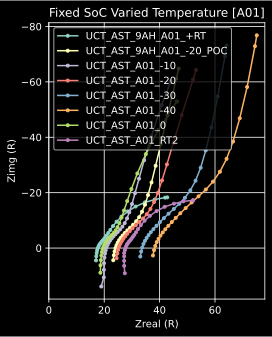

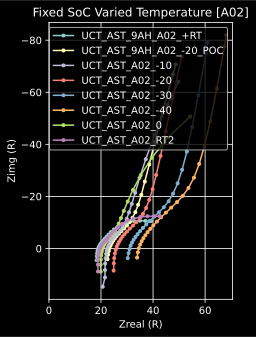

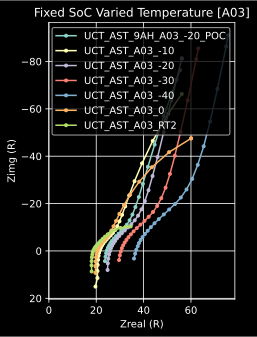

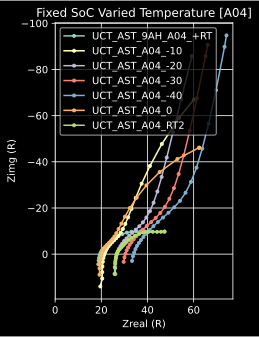

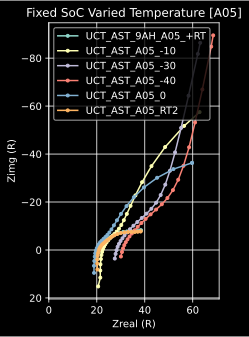

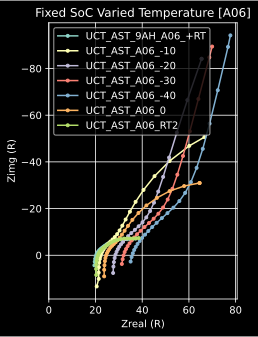

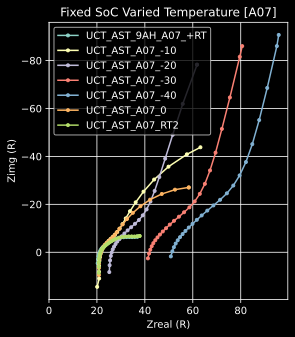

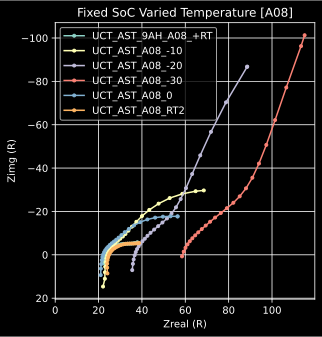

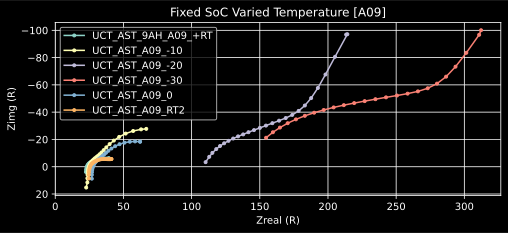

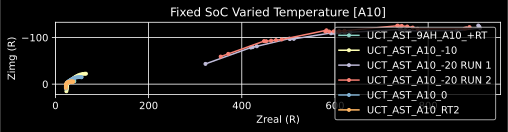

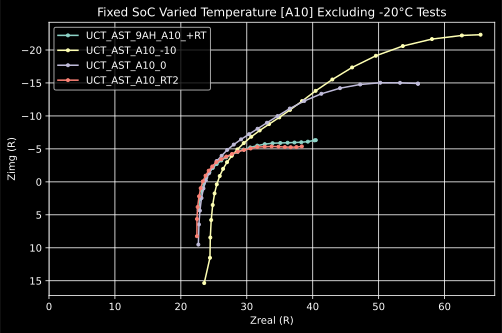

In [7]:
def plotAllSocSpectra(eisSoc):
	for battery in eisSoc:
		plot = plt.figure().add_subplot();
		for spectra in eisSoc[battery]:
			spectraLabel = eisSoc[battery][spectra][1]["Comment"]

			plot = eisSoc[battery][spectra][0].plot(
				x = 'Zreal1',
				y = 'Zimg1',
				grid = True,
				marker = '.',
				title = "Fixed SoC Varied Temperature [" + battery + "]",
				label = spectraLabel,
				ax = plot,
				legend = 'reverse'
			)
		plot.set_xlabel('Zreal (R)')
		plot.set_ylabel('Zimg (R)')
		plot.invert_yaxis()
		plot.set_xlim(left = 0)
		plot.set_aspect('equal', adjustable='box')

def plotA10SocSpectra(eisSoc):
	# Special plot for A10 excluding -20°C tests
	plot = plt.figure().add_subplot();
	for spectra in eisSoc["A10"]:
		if "UCT_AST_A10_-20" not in spectra:
			spectraLabel = eisSoc["A10"][spectra][1]["Comment"]

			plot = eisSoc["A10"][spectra][0].plot(
				x = 'Zreal1',
				y = 'Zimg1',
				grid = True,
				marker = '.',
				title = "Fixed SoC Varied Temperature [A10] Excluding -20°C Tests",
				label = spectraLabel,
				ax = plot,
			)
	plot.set_xlabel('Zreal (R)')
	plot.set_ylabel('Zimg (R)')
	plot.invert_yaxis()
	plot.set_xlim(left = 0)
	plot.set_aspect('equal', adjustable='box')
		
plotAllSocSpectra(eisSoc)
plotA10SocSpectra(eisSoc)
